In [71]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

import psalm_scraper
import psalm_preprocessor as prp

%matplotlib inline

First let's gather all the psalms as we've already done

In [72]:
first = 1
last = 150

#get corpus
ps_dict = psalm_scraper.create_ps_dict(first_psalm = first, last_psalm = last, verbose = False)

Here we randomly sample 80% of the psalms into a training set, reserving the remaining 20% for a test set

In [73]:
def sample_from_dict(d, sample=10):
    train_keys = sorted(random.sample(list(d), sample))
    test_keys = [x for x in list(d.keys()) if x not in train_keys]
    train_values = [d[k] for k in train_keys]
    test_values = [d[k] for k in test_keys]
    return dict(zip(train_keys, train_values)), dict(zip(test_keys, test_values))

train_psalms, test_psalms = sample_from_dict(ps_dict, sample = int(len(ps_dict)*0.8))

In [74]:
print(train_psalms.keys())

print(test_psalms.keys())

dict_keys([3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 58, 59, 60, 62, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 114, 115, 116, 117, 119, 120, 123, 124, 125, 126, 127, 128, 130, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150])
dict_keys([1, 2, 5, 8, 17, 39, 41, 49, 51, 57, 61, 63, 66, 68, 81, 84, 89, 92, 95, 107, 110, 112, 113, 118, 121, 122, 129, 131, 132, 147])


Now let's gather the labels

In [75]:
outcomes_df = pd.read_csv('psalms_sentiment.csv')
outcomes = np.array(outcomes_df['positive'])

In [76]:
#need to use x-1 due to mismatch between psalm number and python indexing
train_y = [outcomes[x-1] for x in list(train_psalms.keys())]
test_y = [outcomes[x-1] for x in list(test_psalms.keys())]

In [77]:
print(train_y)
print(test_y)

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


Now we build our corpus and vocabulary on the training data. Recall we want to have the corpi in their cleaned and tokenized versions, so we're using `clean_corpus()`. Finally we're constructing our vocabulary based on the training data. 

In [78]:
train_corpus = prp.clean_corpus(train_psalms)
test_corpus = prp.clean_corpus(test_psalms)

vocab = prp.build_vocabulary(train_corpus)

In [79]:
print(f'The vocabulary contains: {len(vocab)} unique words')

The vocabulary contains: 1958 unique words


In [80]:
#print(vocab)

## Convert psalms to tensors

Because all the tensors have to be of the same length to be used in a neural network, we need to get the length of the longest tensor in order to pad the remaining tensors. In this case, the longest psalm (119) is much larger than the others. We can see it at the end of the list of the lengths of all the psalms (1034 tokens).

In [81]:
def max_length(training_x, validation_x):
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """

    max_len = np.max([len(t) for t in training_x + validation_x])
    
    return int(max_len)

max_len = max_length(train_corpus, test_corpus)
print(f'The length of the longest psalm is {max_len} tokens.')

The length of the longest psalm is 1034 tokens.


In [82]:
[len(t) for t in train_corpus + test_corpus]

[49,
 66,
 73,
 134,
 147,
 151,
 60,
 66,
 47,
 58,
 42,
 81,
 351,
 124,
 72,
 88,
 223,
 52,
 71,
 138,
 75,
 128,
 79,
 94,
 87,
 204,
 99,
 149,
 144,
 220,
 93,
 294,
 134,
 170,
 107,
 48,
 183,
 153,
 91,
 66,
 103,
 159,
 74,
 59,
 46,
 174,
 89,
 96,
 139,
 90,
 99,
 79,
 111,
 62,
 265,
 46,
 186,
 175,
 165,
 177,
 73,
 85,
 141,
 514,
 120,
 143,
 56,
 121,
 87,
 129,
 46,
 121,
 139,
 98,
 43,
 138,
 106,
 89,
 83,
 74,
 36,
 75,
 199,
 142,
 260,
 294,
 336,
 93,
 226,
 72,
 53,
 103,
 113,
 16,
 1034,
 40,
 35,
 51,
 45,
 49,
 52,
 50,
 45,
 29,
 22,
 139,
 193,
 70,
 75,
 153,
 101,
 92,
 55,
 99,
 137,
 147,
 80,
 94,
 68,
 41,
 49,
 82,
 95,
 63,
 126,
 110,
 85,
 142,
 140,
 96,
 56,
 77,
 144,
 324,
 117,
 108,
 353,
 105,
 92,
 279,
 63,
 74,
 55,
 199,
 44,
 57,
 49,
 26,
 125,
 134]

In [83]:
def padded_sequence(psalm, vocab_dict, max_len, unk_token='[UNK]'):
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """
    
    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict[unk_token] 
    
    # First convert the words to integers by looking up the vocab_dict
    tensor = []
    [tensor.append(vocab_dict[word]) if word in vocab_dict else tensor.append(unk_ID) for word in psalm]

    # Then pad the tensor with zeroes up to the length max_len
    padded_tensor = np.pad(tensor, (0, max_len - len(tensor)))

    return list(padded_tensor)

In [84]:
#Creating padded lists to be turned into tensors
train_psalm_padded = [padded_sequence(x, vocab, max_len) for x in train_corpus]
test_psalm_padded = [padded_sequence(x, vocab, max_len) for x in test_corpus]

## Creating Tensorflow model

Here we create a standard sequential tensorflow NN model with an embedding layer followed by a pooling layer, and finally a dense layer with sigmoid activation for the final prediction step.

In [85]:
def create_model(num_words, embedding_dim, max_len):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
        
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
    ]) 
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [86]:
num_words = len(vocab)
model = create_model(num_words=num_words, embedding_dim=4, max_len=max_len)

In [94]:
# Prepare the data
train_x_prepared = np.array(train_psalm_padded)
val_x_prepared = np.array(test_psalm_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(test_y)

print('The data is prepared for training!\n')

# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20
4/4 [==============================] - 0s 35ms/step - loss: 0.6731 - accuracy: 0.5667 - val_loss: 0.6281 - val_accuracy: 0.7667
Epoch 2/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6730 - accuracy: 0.5667 - val_loss: 0.6276 - val_accuracy: 0.7667
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 0.6726 - accuracy: 0.5667 - val_loss: 0.6278 - val_accuracy: 0.7667
Epoch 4/20
4/4 [==============================] - 0s 21ms/step - loss: 0.6725 - accuracy: 0.5667 - val_loss: 0.6281 - val_accuracy: 0.7667
Epoch 5/20
4/4 [==============================] - 0s 21ms/step - loss: 0.6722 - accuracy: 0.5667 - val_loss: 0.6278 - val_accuracy: 0.7667
Epoch 6/20
4/4 [==============================] - 0s 21ms/step - loss: 0.6721 - accuracy: 0.5667 - val_loss: 0.6280 - val_accuracy: 0.7667
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 0.6718 - accuracy: 0.5667 - val_loss: 0.6278 - va

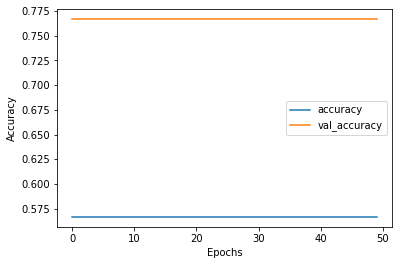

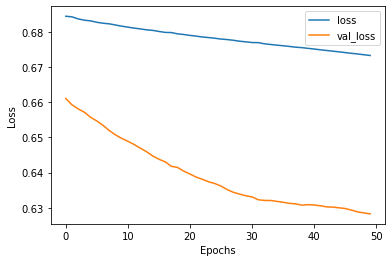

In [91]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [93]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:5], val_x_prepared[-5:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 34ms/step


array([[0.56935817],
       [0.5686971 ],
       [0.5672718 ],
       [0.5706433 ],
       [0.56362844],
       [0.5688837 ],
       [0.5683658 ],
       [0.5704046 ],
       [0.5667924 ],
       [0.57199776]], dtype=float32)